# Тестовое задание для Analytics summer camp

#### 2.	Перед тобой датасет некой интернет-компании. 

##### import modules

In [1]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
df = pd.read_csv(glob('*.csv')[0], parse_dates=['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52724 entries, 0 to 52723
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                52724 non-null  datetime64[ns]
 1   source              52724 non-null  object        
 2   medium              52724 non-null  object        
 3   delivery_available  52724 non-null  object        
 4   device_type         52724 non-null  object        
 5   promo_activated     52724 non-null  object        
 6   filter_used         52724 non-null  object        
 7   pageviews           52724 non-null  int64         
 8   visits              52724 non-null  int64         
 9   productClick        52724 non-null  int64         
 10  addToCart           52724 non-null  int64         
 11  checkout            52724 non-null  int64         
 12  transactions        52724 non-null  int64         
 13  revenue             52724 non-null  float64   

#### a.	Какой рекламный канал принёс больше всего дохода за всё время?
## Ответ: yandex (263161700)

Решение смотри ниже

In [3]:
source_revenue = df.loc[df['medium'].isin(['cpc','cpa'])]

In [4]:
source_revenue = source_revenue.groupby(by = ['source'])['revenue'].sum().reset_index()
source_revenue.sort_values('revenue', ascending = False)

,source,revenue
12,yandex,263161700.0
6,google,165179729.0
1,admitad,65738858.0
4,eLama,16432390.0
3,cityads,14290767.0
10,other,789066.0
0,actionpay,555717.0
2,advertise,440436.0
9,opmcpa,393825.0
11,vk,13083.0


#### b.	Как изменился средний чек транзакции после введения коронавирусных ограничений? Как он изменился для пользователей, покупающих с промокодом и без? (параметр «promo_activated»)

##### Сложно определить точку отчёта. Пусть это будет 5 марта мэр Москвы ввёл режим повышенной готовности в Москве
###### источник: https://rg.ru/2020/03/05/moscow-ukaz12-reg-dok.html

In [72]:
# сделаем копию dataframe
avg_purch_all = df[:]
# высчитаем среднее значение за 1 транзацкию
avg_purch_all.insert(14, 'avg_revenue', (avg_purch_all['revenue'] / avg_purch_all['transactions']), True)

# 
avg_purch_all_before = avg_purch_all[avg_purch_all['date'] < '05.03.2020'][:]
avg_purch_all_after = avg_purch_all[avg_purch_all['date'] > '05.03.2020'][:]

avg_purch_all_after_2m = avg_purch_all.loc[(avg_purch_all['date'] > '05.03.2020')&(avg_purch_all['date'] < '05.05.2020')][:]



##### Разделим вопрос на 2
1. Как изменился средний чек транзакции после введения коронавирусных ограничений?
2. Как он изменился для пользователей, покупающих с промокодом и без? (параметр «promo_activated»)

#####  1. Как изменился средний чек транзакции после введения коронавирусных ограничений?
Ответ:
- на 15.7% средний чек транзакции уменьшился, если сравнивать первые два месяца с остальными месяцами
- на 8.2% средний чек транзакции уменьшился, если сравнивать первые два месяца с мартом и апрелем(летом, некоторые ограничения были отменены)

Решение смотри ниже


Для начала посмотроим на то как менялся средний чек транзакции на протяжении всего периода и убедимся, что происходили какие либо изменения

In [73]:
# создадим копию DataFrame
avg_purch_all_for_plot = avg_purch_all[:]

# оставим только месяцы, чтобы было легче группировать 
avg_purch_all_for_plot['date'] = avg_purch_all_for_plot['date'].dt.month

#сгруппируем данные по месяцам
avg_purch_all_for_plot = avg_purch_all_for_plot.groupby(by = 'date').agg({
    'avg_revenue':'mean',
    'transactions':'mean'}).reset_index()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


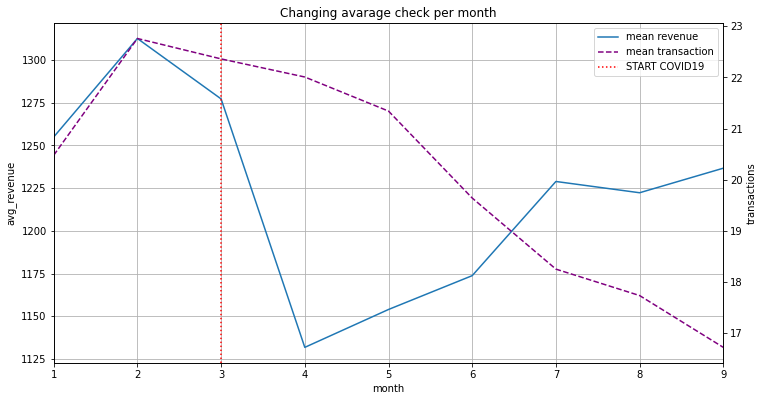

In [74]:
# построим график
plt.figure(figsize=(12,6.25))
plt.grid()
line1 = sns.lineplot(
    data = avg_purch_all_for_plot, 
    x = avg_purch_all_for_plot['date'], 
    y =  avg_purch_all_for_plot['avg_revenue']
    )
line1.legend().set_visible(False)
line1.set_xlabel('month')

ax2 = plt.twinx()
line2 = sns.lineplot(
    data = avg_purch_all_for_plot, 
    x = avg_purch_all_for_plot['date'], 
    y =  avg_purch_all_for_plot['transactions'],
    ax=ax2, color = 'purple', linestyle = '--')

    
line3 = plt.axvline(3, color = 'red', label = 'Start COVID19', linestyle = 'dotted')
plt.title('Changing avarage check per month')
plt.legend([line1.get_lines()[0], line2.get_lines()[0],line3],['mean revenue','mean transaction','START COVID19'])
plt.xlabel('month')
plt.xlim(1,9)
plt.show()

##### На графике видно, что после введения ковид-ограничений средний чек транзакции упал
##### Гипотреза: мае-июле уменьшили количество каналов превличения трафика и общий рекламный бюджет. На это указывает уменьшение среднего количества транзакций и увеличение среднего чека 


##### Посчитаем как изменился средний чек до короновирусных ограничений и после
Что будем сравнимать:

1. Период до и все месяцы после
2. Период до и 2 месяца после


In [75]:
# сравниваем период до и все месяцы после
# высчитываем среднее значение до короновирусных ограничей
avg_cost_before = (avg_purch_all_before['revenue'].sum() / avg_purch_all_before['transactions'].sum())

# высчитываем среднее значение до короновирусных ограничей
avg_cost_after = (avg_purch_all_after['revenue'].sum() / avg_purch_all_after['transactions'].sum())
perc_diff = avg_cost_after / avg_cost_before
print(round(perc_diff * 100 -100,3))
print(round((avg_purch_all_after_2m['revenue'].sum() / avg_purch_all_after_2m['transactions'].sum()) / avg_cost_before *100 - 100, 3))

-1.57
-8.19


#### Как он изменился для пользователей, покупающих с промокодом и без? (параметр «promo_activated»)
В этом блоке мы также рассмотрим 3 периода (до, 2 месяца после, 7 месяцев)
1. Период до и все месяцы после
    - средний чек у людей с промокодом стал больше на 2.78%
    - средний чек у людей без промокода стал меньше на 8.92%

2. Период до и 2 месяца после
    - средний чек у людей с промокодом стал меньше на -0.8% 
    - средний чек у людей без промокода стал меньше на -13.25%

Решение смотри ниже

In [76]:
promo_activated = df[:]
promo_activated.insert(14, 'avg_revenue', (promo_activated['revenue'] / promo_activated['transactions']), True)

In [77]:
# сначала получим данные по промокодам до пандемии
avg_promo_yes_before = avg_purch_all_before.loc[avg_purch_all_before['promo_activated'] == 'yes']['avg_revenue'].mean()#.i.groupby(by ='promo_activated')['avg_revenue'].mean()
avg_promo_no_before = avg_purch_all_before.loc[avg_purch_all_before['promo_activated'] == 'no']['avg_revenue'].mean()
print(f'yes: {avg_promo_yes_before} \n no: {avg_promo_no_before}')

yes: 1205.8582267737595 
 no: 1278.588570604049


In [78]:
# данные по промокодам после введения короновирусных ограничений
avg_promo_yes_after = avg_purch_all_after.loc[avg_purch_all_after['promo_activated'] == 'yes']['avg_revenue'].mean()
avg_promo_no_after = avg_purch_all_after.loc[avg_purch_all_after['promo_activated'] == 'no']['avg_revenue'].mean()
print(f'yes: {avg_promo_yes_after} \n no: {avg_promo_no_after}')
print(f'yes: {round(avg_promo_yes_after/avg_promo_yes_before*100-100,2)}% \n no: {round(avg_promo_no_after/avg_promo_no_before*100-100,2)}%')


yes: 1239.3972667760822 
 no: 1164.540773767593
yes: 2.78% 
 no: -8.92%


In [79]:
# данные по промокодам после введения короновирусных ограничений (первые 2 месяца)
avg_promo_yes_after_2m = avg_purch_all_after_2m.loc[avg_purch_all_after_2m['promo_activated'] == 'yes']['avg_revenue'].mean()
avg_promo_no_after_2m = avg_purch_all_after_2m.loc[avg_purch_all_after_2m['promo_activated'] == 'no']['avg_revenue'].mean()
print(f'yes: {avg_promo_yes_after_2m} \n no: {avg_promo_no_after_2m}')
print(f'yes: {round(avg_promo_yes_after_2m/avg_promo_yes_before*100-100,2)}% \n no: {round(avg_promo_no_after_2m/avg_promo_no_before*100-100,2)}%')


yes: 1196.169024449091 
 no: 1109.1622793209947
yes: -0.8% 
 no: -13.25%


#### c.	Можно ли с уверенностью в 95% сказать, что CR (коэффициент конверсии в транзакцию) в выходные дни отличается от CR в будние дни?

In [57]:
# def dayofweekmaker(df):
#     dayofweek = {
#         0:'Monday',
#         1:'Tuesday',
#         2:'Wednesday',
#         3:'Thursday',
#         4:'Friday',
#         5:'Saturday',
#         6:'Sunday'
#     }
#     return dayofweek.get(df)

In [62]:
def daymark(df):
    if df in (5,6):
        return 'weekend'
    else:
        return 'workday'

In [63]:
cr_df = df[:]
cr_df.insert(3,'conversion_rate',  round(cr_df['transactions'] / cr_df['visits'] * 100, 2), True)
cr_df.insert(3,'dayofweek', cr_df['date'].dt.dayofweek , True)
# cr_df.insert(3, 'day', cr_df['dayofweek'].apply(dayofweekmaker), True)
cr_df.insert(3, 'day', cr_df['dayofweek'].apply(daymark), True)


In [84]:

new_cr = cr_df.groupby(by = 'day').agg({'transactions': 'sum', 'visits':'sum'}).reset_index()
new_cr.insert(3, 'CR', (new_cr['transactions'] / new_cr['visits']), True)

In [85]:
new_cr

,day,transactions,visits,CR
0,weekend,368210,2154359,0.170914
1,workday,691164,4553152,0.151799


In [ ]:
# данные по промокодам после введения короновирусных ограничений (первые 2 месяца)
avg_promo_yes_after_2m = avg_purch_all_after_2m.loc[avg_purch_all_after_2m['promo_activated'] == 'yes']['avg_revenue'].mean()
avg_promo_no_after_2m = avg_purch_all_after_2m.loc[avg_purch_all_after_2m['promo_activated'] == 'no']['avg_revenue'].mean()
print(f'yes: {avg_promo_yes_after_2m} \n no: {avg_promo_no_after_2m}')
print(f'yes: {round(avg_promo_yes_after_2m/avg_promo_yes_before*100-100,2)}% \n no: {round(avg_promo_no_after_2m/avg_promo_no_before*100-100,2)}%')


yes: 1196.169024449091 
 no: 1109.1622793209947
yes: -0.8% 
 no: -13.25%


#### d.	Вам необходимо спрогнозировать объем дохода, полученного с пользователей, приведенных на сайт контекстной рекламой (medium = cpc) на полгода вперед. Опишите, как бы вы подошли к этой задаче и какие дополнительные данные вам понадобятся?


In [26]:
# получим список размещений
df[['source','medium']][df['medium'] == 'cpc']['source'].unique()

array(['yandex', 'google', 'eLama', 'yandex_direct', 'other', 'youtube',
       'facebook', 'instagram', 'mytarget', 'vk'], dtype=object)

#### Из всех размещений контекстными являются только yandex, yandex_direct и google(на данный момент рекламамироваться в нём на территории РФ невозможно).


Алгоритм действий
0. Беру данные за предыдущий год (если есть)
1. Строю воронку для каждого источника, чтобы понять конверсию в следующий шаг
2. Масштабирование результата. Запрашиваю у специалистов ёмкость по каждому ключевому(конверсионному) слову, сколько можем получить трафика, какая будет стоимость клика при 100+% трафика (или сам через кейколлектор и планировщик кампании в Google)
3. На основе этих данных рассчитываю максимальное количество транзакций, которое можем получить, сравниваю полученное значение с KPI-клиента. Если всё сходится отправляю специалисту на проверку (ему же это всё потом вести =) )
